In [59]:
import networkx as nx
from nltk import word_tokenize, pos_tag, download
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

In [49]:
# download relevant nltk datasets
download("wordnet")
download("omw-1.4")
download("punkt")
download("averaged_perceptron_tagger")
download("stopwords")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
# load pages
with open("cains_jawbone.txt", "r", encoding="utf-8") as f:
    pages = f.read().split("\n\n")

In [51]:
# preprocess and tokenize pages
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def get_pos(tag: str) -> str | None:
    match tag[0]:
        case "J":
            return wordnet.ADJ
        case "R":
            return wordnet.ADV
        case "N":
            return wordnet.NOUN
        case "V":
            return wordnet.VERB
        case _:
            return None

def preprocess(text: str) -> str:
    tokens = [token for token in word_tokenize(text.lower())]
    tagged = [(word, get_pos(tag)) for word, tag in pos_tag(tokens)]
    lemmatized = [lemmatizer.lemmatize(word, pos=tag) for (word, tag) in tagged if tag is not None]
    words = [word for word in lemmatized if len(word) > 2 and word not in stop_words and word.isalpha()]
    return " ".join(words)

data = [preprocess(page) for page in pages]

In [52]:
# vectorize tokens to frequencies
vectorizer = TfidfVectorizer(stop_words="english")
freqs = vectorizer.fit_transform(data)

In [103]:
# calculate cosine similarities between pages
weights = np.zeros((len(pages), len(pages)))
stats = []
for i in range(len(pages)):
    for j in range(len(pages)):
        weight = cosine_similarity(freqs[i], freqs[j]).flatten()[0]
        weights[i, j] = weight
        if i > j:
            stats.append(weight)

In [104]:
stats = np.array(stats)

In [105]:
print(stats.min(), stats.mean(), stats.max(), stats.std())

0.0 0.030317195394607487 0.1990180757927755 0.018858754664633194


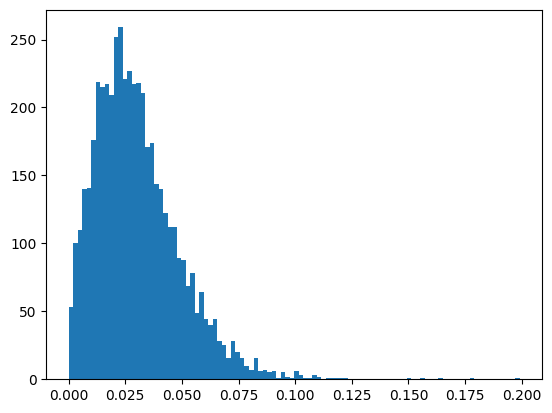

In [121]:
plt.hist(stats, bins=100)
plt.show()

In [114]:
def generate_graph(weights: np.ndarray, threshold: float = 0.03) -> nx.Graph:
    n = weights.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i+1, n):
            if weights[i, j] >= threshold:
                G.add_edge(i, j)
    return G

In [122]:
G = generate_graph(weights, 0.05)

In [123]:
len(G.edges)

687

In [125]:
def n_communities(G: nx.Graph) -> float:
    return len(nx.community.louvain_communities(G))

In [126]:
n_communities(G)

8

In [130]:
# or alternatively with whole weighted graph
G = nx.complete_graph(len(pages))
for (i, j) in G.edges:
    G.edges[i, j]["weight"] = cosine_similarity(freqs[i], freqs[j]).flatten()[0]

comms = nx.community.louvain_communities(G, weight="weight")

In [137]:
len(comms)

5

Communities

- 15 16 33 42 44 51 77 82 83 97 
- 0 6 8 13 14 19 24 27 30 49 50 59 61 81 85 88 94 95 
- 1 3 4 10 12 20 37 39 40 41 43 46 48 52 57 60 62 65 67 71 72 75 76 79 84 86 89 92 93 96 99 
- 5 11 17 22 23 25 26 29 34 35 36 53 54 55 58 68 70 73 74 80 90 91 98 
- 2 7 9 18 21 28 31 32 38 45 47 56 63 64 66 69 78 87 

NMF

- 19 27 32 39 46 64 65 75 77 80 92
- 2 7 9 18 21 38 45 47 56 63 69 78 87
- 11 23 26 28 29 35 37 52 53 55 58 68 70 73 74 88 89 98
- 1 3 10 13 20 24 25 30 31 34 41 48 57 62 71 76 79 81 84 86 93 96 99
- 4 5 12 15 16 17 22 33 40 42 43 44 51 54 60 61 67 72 82 83 91 97
- 0 6 8 14 36 49 50 59 66 85 90 94 95

In [138]:
# Graph Traversal Algorithm?